In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks
import netCDF4
import xarray as xr
from datetime import datetime, timedelta
import oceanlyz
import os

C:\Users\lachl\AppData\Local\Temp\ipykernel_17724\618615904.py:7: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
# May need to adjust header

def read_data(csv_file, head=9, cols=(1,2,3,4,5)):
    
    data = pd.read_csv(csv_file, header=head, usecols=cols, 
                       names = ['dates','pressure_raw','sea_pressure', 'depth', 'velocity'], encoding="ISO-8859-1")
    

    time_format = "%Y-%m-%d %H:%M:%S.%f"  
    data['dates'] = pd.to_datetime(data['dates'], format=time_format)
    data['pressure'] = data['pressure_raw'].astype(float)
    data['sea_pressure'] = data['sea_pressure'].astype(float)
    data['depth'] = data['depth'].astype(float)
    data['velocity'] = data['velocity'].astype(float)
    
    # Separate time and date
    #data['date'] = pd.to_datetime(data['dates']).dt.date
    #data['time'] = pd.to_datetime(data['dates']).dt.time

    return data

def trim_time_interval(dataframe, start, end, timecol = 'dates'):
    
    trim_dataframe = dataframe[(dataframe[timecol] >= start) & (dataframe[timecol] <= end)]
    
    trim_dataframe = trim_dataframe.reset_index()
    
    return trim_dataframe.copy()

In [33]:
raw_data = read_data('RBR_PT.csv')


In [35]:
### We need to use sea pressure for the PT, not total pressure:

raw_data['pressure'] = raw_data['sea_pressure']
raw_data.drop(columns = 'sea_pressure')

,dates,pressure_raw,depth,velocity,pressure
0,2022-10-06 23:00:01.125,12.260834,2.111050,0.112155,2.128334
1,2022-10-06 23:00:01.250,12.274468,2.124573,0.099812,2.141968
2,2022-10-06 23:00:01.375,12.286715,2.136721,0.081249,2.154215
3,2022-10-06 23:00:01.500,12.295434,2.145369,0.058645,2.162934
4,2022-10-06 23:00:01.625,12.301304,2.151191,0.032355,2.168804
...,...,...,...,...,...
345587,2022-10-07 10:59:59.500,12.209452,2.060085,-0.027911,2.076952
345588,2022-10-07 10:59:59.625,12.209452,2.060085,-0.048869,2.076952
345589,2022-10-07 10:59:59.750,12.209452,2.060085,-0.081228,2.076952
345590,2022-10-07 10:59:59.875,12.180563,2.031431,-0.092234,2.048063


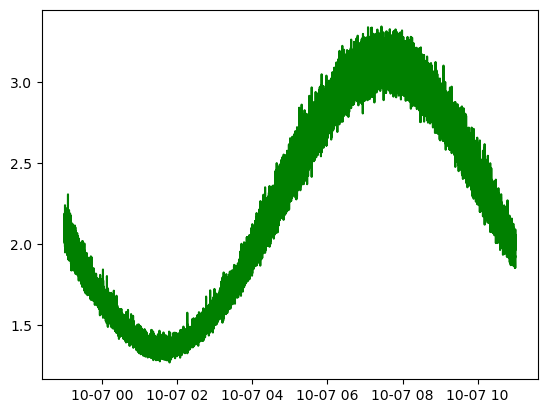

In [37]:
plt.plot(raw_data['dates'], raw_data['pressure'], c = 'g')

In [39]:
def get_bursts(data, dispout = False):
    Hz=8
    bl=15*60 #burst length 5min x 60sec
    nbl = int(np.floor(len(data)/(bl*Hz)))
    if dispout:
        print('Number of bursts is %s and burst duration is %s seconds' %(nbl, bl))
        if nbl>1000:
            print('WARNING:')
            print('Oceanlyz has a limit of 900 bursts. Try cut the data and analyse separately')
            print('Try cutting the data into %s'%(nbl/900))
        print('Hz = %s'%(Hz))
        print('')    
        print('Sensor start:')
        print(np.min(data.dates))
        print('Sensor finish:')
        print(np.max(data.dates))
        print('Total duration: ')
        td=np.max(data.dates)-np.min(data.dates)
        mins = td.days*24*60 + td.seconds/60
        print('%s mins' %(mins))
    return Hz, bl, nbl

In [47]:
def run_oceanlyz_zero_cross(data):
    #start Oceanlyz 
    ocn = oceanlyz.oceanlyz()
    depth =  raw_data['depth'].astype(float)
    ocn.data = depth 
    
    #set up oceanlyz parameters:
    ocn.InputType='waterlevel'
    ocn.OutputType='wave'
    #ocn.AnalysisMethod='spectral'
    ocn.AnalysisMethod='zerocross' #We can also select a 'zero-crossing' method of wave analysis
    ocn.n_burst=nbl
    ocn.burst_duration=bl
    ocn.fs=Hz                         #Samples are at 8 Hz
    ocn.SeparateSeaSwell='no'
    #ocn.seaswellCalc='on'
    ocn.fmin=0.004
    ocn.fmax=1
    ocn.heightfrombed=0.05           #Only required if ocn.InputType='pressure'
    ocn.dispout='no'
    ocn.Rho=1024                     #Seawater density (Varies)
    
    #Run onceanlyz:
    ocn.runoceanlyz()
    
    return ocn.wave

In [49]:
def run_oceanlyz_spectral(data):
    #start Oceanlyz 
    ocn = oceanlyz.oceanlyz()
    pressure_pa =  raw_data['pressure'] * 10000
    ocn.data = pressure_pa #Convert dbar to pa
    
    #set up oceanlyz parameters:
    ocn.InputType='pressure'
    ocn.OutputType='wave+waterlevel'
    ocn.AnalysisMethod='spectral'
    #ocn.AnalysisMethod='zerocross' #We can also select a 'zero-crossing' method of wave analysis
    ocn.n_burst=nbl
    ocn.burst_duration=bl
    ocn.fs=Hz                         #Samples are at 8 Hz or 2Hz
    ocn.SeparateSeaSwell='no'
    ocn.seaswellCalc='off'
    ocn.fmin=0.004
    ocn.fmax=1
    ocn.fmaxpcorrCalcMethod='auto'   #Only required if ocn.InputType='pressure'
    ocn.Kpafterfmaxpcorr='constant'  #Only required if ocn.InputType='pressure'
    ocn.fminpcorr=0.15            #Only required if ocn.InputType='pressure'
    ocn.fmaxpcorr=0.55               #Only required if ocn.InputType='pressure'
    ocn.heightfrombed=0.05
    ocn.tailpower=-3  
    ocn.dispout='no'
    ocn.Rho=1024                                  #Seawater density (Varies)
    #ocn.pressureattenuation = 'off'
    #Run onceanlyz:
    ocn.runoceanlyz()
    
    return ocn.wave

In [51]:

outputspec = []
outputzer = []

Hz, bl, nbl = get_bursts(raw_data,'PT')
outputspec.append(run_oceanlyz_spectral(data))
outputzer.append(run_oceanlyz_zero_cross(data))
print('Processed site '+str('PT'))

Number of bursts is 47 and burst duration is 900 seconds
Hz = 8

Sensor start:
2022-10-06 23:00:01.125000
Sensor finish:
2022-10-07 11:00:00
Total duration: 
719.9666666666667 mins
--------------------------------------------------
OCEANLYZ Ver 2.0
www.ArashKarimpour.com
Copyright (C) 2012 - 2025  Arash Karimpour
--------------------------------------------------
Parameters (only required ones used)
--------------------------------------------------
InputType           :  pressure
OutputType          :  wave+waterlevel
-------------------------------
AnalysisMethod      :  spectral
-------------------------------
n_burst             :  47
burst_duration      :  900
fs                  :  8
-------------------------------
fmin                :  0.004
fmax                :  1
-------------------------------
fmaxpcorrCalcMethod :  auto
Kpafterfmaxpcorr    :  constant
fminpcorr           :  0.15
fmaxpcorr           :  0.55
heightfrombed       :  0.05
-------------------------------
dispout

In [57]:
print(outputzer[0]['Field_Names'])
print(outputzer[0]['Burst_Data'])


['Hs, Hz, Tz, Ts,  Field_Names, Burst_Data']
[[2.11105023 2.12457295 2.13672081 ... 2.05678587 2.05928504 2.05832926]
 [2.05306396 2.04720208 2.04032659 ... 1.8747702  1.86629244 1.85609652]
 [1.84476877 1.83239054 1.82153413 ... 1.78330381 1.77498293 1.76387186]
 ...
 [2.43831189 2.45837921 2.48027701 ... 2.20581813 2.22003992 2.23461529]
 [2.24909649 2.26290286 2.2760899  ... 2.24255767 2.25269648 2.26087796]
 [2.26729391 2.27317288 2.27674978 ... 2.0380012  2.03158518 2.02351109]]


In [59]:
water_level = []
for m in range(len(outputzer[0]['Burst_Data'])):
    mean = np.mean(outputzer[0]['Burst_Data'][m])
    water_level.append(mean)
    outputzer[0]['water_level'] = water_level

In [61]:
def smooth_line(data, sigma):
    return gaussian_filter1d(data, sigma=sigma)

def plot_ocn_waves(data, var, save = False):
    waves = data[var] #zero-moment wave height

    fig = plt.figure(figsize=(20,6), dpi=60) 
    ax =plt.gca()

    plt.plot(waves, c = 'lightgrey')


    plt.plot(waves, c = 'b')

    plt.xlabel('Burst Number')
    plt.ylabel('Hs (m)')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    #plt.xlim(0,140)
    #plt.ylim(0.1,0.3)

    plt.title(f'{var} Waves')
    ax.set_ylabel(f'{var} (m)',fontsize=10)
    ax.set_xlabel('Burst Number',fontsize=10)
    plt.grid()
    plt.show()
    
    
    

    #plt.legend(loc=0, frameon=True)
    #plt.savefig('%s_wave.jpg'%(name))

    #print('Burst length = %s mins' %(ocn.burst_duration/60))
    if save:
        plt.savefig('{profile}_wave_plot.png'.format(profile = colour))

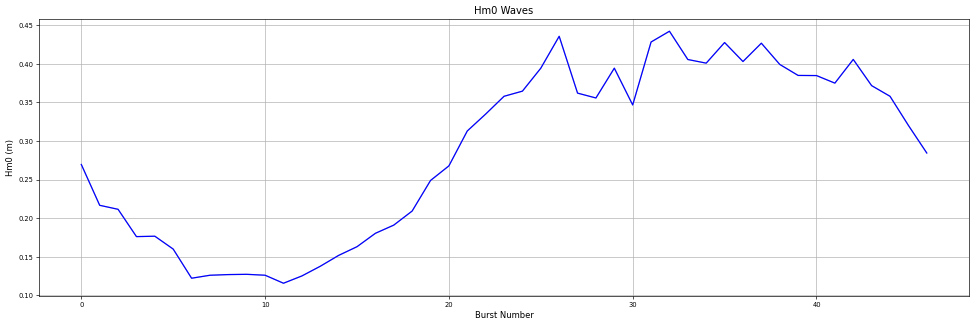

In [63]:
plot_ocn_waves(outputspec[0], 'Hm0')

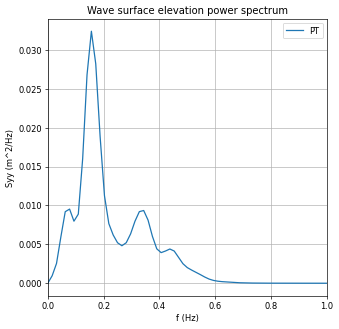

In [65]:
fig = plt.figure(figsize=(6,6), dpi=60) 
ax =plt.gca()
ax.plot(outputspec[0]['f'][0,:],outputspec[0]['Syy'][0,:], label = 'PT')
ax.set_xlabel('f (Hz)')
ax.set_xlim(0,1.0)
ax.set_ylabel('Syy (m^2/Hz)')
plt.legend()
plt.title(f'Wave surface elevation power spectrum')
ax.grid()
plt.show()

(0.1, 0.6)

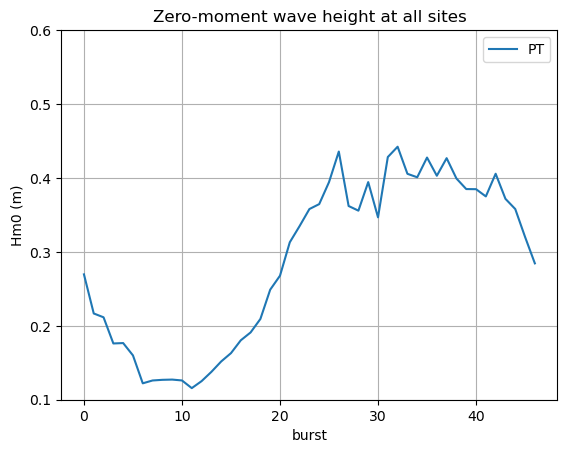

In [67]:

plt.plot(outputspec[0]['Hm0'], label = 'PT')
plt.grid()
plt.legend()
plt.title('Zero-moment wave height at all sites')
plt.ylabel('Hm0 (m)')
plt.xlabel('burst')
plt.ylim(0.1,0.6)


In [71]:
def burst_to_time(data, start, stop, nbl):
    step = (end - start) / (nbl-1)
    t = np.arange(start, stop, step).astype(datetime)
    if len(t) > len(data['Hs']):
        t = t[:-1]
    return t

    return t


def get_summary_zero(data, t):
    df = pd.DataFrame()
    df['time'] = t
    df['Hs'] = data['Hs']
    df['Hz'] = data['Hz']
    df['Tz'] = data['Tz']
    df['Ts'] = data['Ts']
    df['water_level'] = data['water_level']
    return df

def get_summary_spec(data, t):
    df = pd.DataFrame()
    df['time'] =t
    for k in range(1,len(data['Eta'])):
        df['Eta'] = np.mean(data['Eta'][k])
    df['Hm0'] = data['Hm0']
    #df['Hm0sea'] = data['Hm0sea']
    #df['Hm0swell'] = data['Hm0swell']
    df['Tp'] = data['Tp']
    #df['Tpsea'] = data['Tpsea']
    #df['Tpswell'] = data['Tpswell']
    df['fp'] = data['fp']
    #df['fseparation'] = data['fseparation']
    #for k in range (len(data['Syy'])):
    #    df[f'Syy_{k}'] = (data['Syy'][:,k])
    return df

In [73]:
# Start time:
summary_zero = []
summary_spec =[]

print('created summary')
# get start time
start = np.min(raw_data.dates) + timedelta(seconds = bl/2)
#get end time
end = np.max(raw_data.dates)
#get burst length (bl)
Hz, bl, nbl = get_bursts(raw_data, dispout=False)
t = burst_to_time(outputzer[0], start, end, nbl)   
summary_zero.append(get_summary_zero(outputzer[0], t))
summary_spec.append(get_summary_spec(outputspec[0], t))
    

created summary


In [75]:
summary_zero[0].to_csv('Zero_crossing_waves.csv')
summary_spec[0].to_csv('Spectral_waves.csv')